### Research

In [1]:
# Importing the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
import yaml
import psycopg2
import pickle

from sqlalchemy import create_engine
from urllib.parse import quote

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [2]:
# Accessing the params.yaml file
params = yaml.safe_load(open("params.yaml"))['preprocess']

# Importing the required configurations for the database
from config import user, psswd, database, host, port

# URL-encoding the password to encode the "@"
encoded_password = quote(psswd)

# Creating databsase engine
engine = create_engine(f'postgresql+psycopg2://{user}:{encoded_password}@{host}:{port}/{database}')

# Defining the select query
select_query = "SELECT * FROM train_df"

# Executing the query
train_data = pd.read_sql(select_query, engine)

In [3]:
# Describing the data
train_data.describe()

# Dropping null values
train_data = train_data.dropna()

# Dropping the duplicate values
train_data = train_data.drop_duplicates()

In [4]:
# Retriving the columns of the data
cols = train_data.columns

cols

Index(['id', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'loan_status'],
      dtype='object')

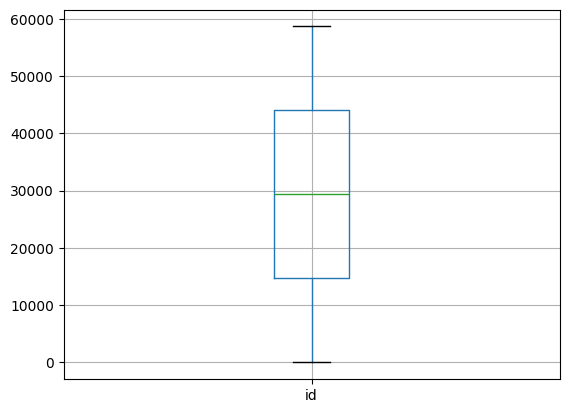

In [5]:
# Creating a boxplot for id
train_data[[cols[0]]].boxplot()
plt.show()

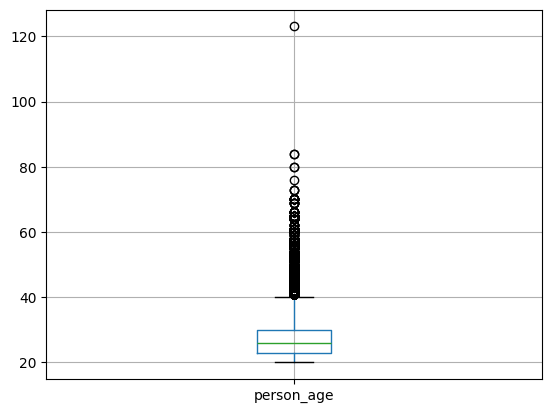

In [6]:
# Creating a boxplot for Age
train_data[[cols[1]]].boxplot()
plt.show()

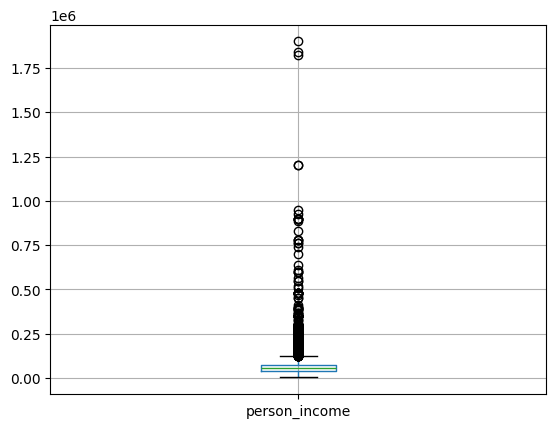

In [7]:
# Creating a boxplot for Income
train_data[[cols[2]]].boxplot()
plt.show()

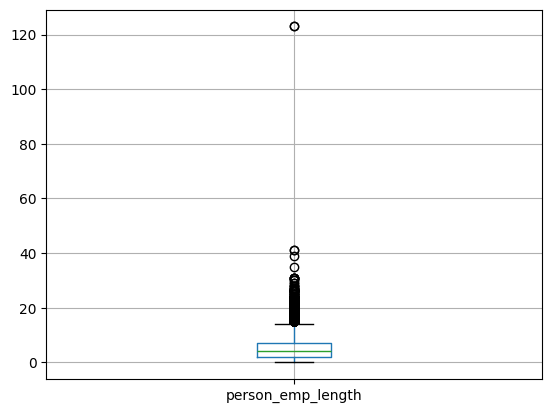

In [8]:
# Creating a boxplot for Employee Length (employee length greater than 120 is a very big outlier that needs to be removed)
train_data[[cols[4]]].boxplot()
plt.show()

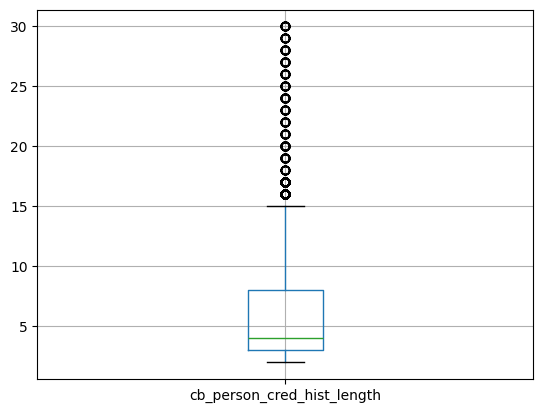

In [9]:
# Creating a boxplot for Credit History Length
train_data[[cols[6]]].boxplot()
plt.show()

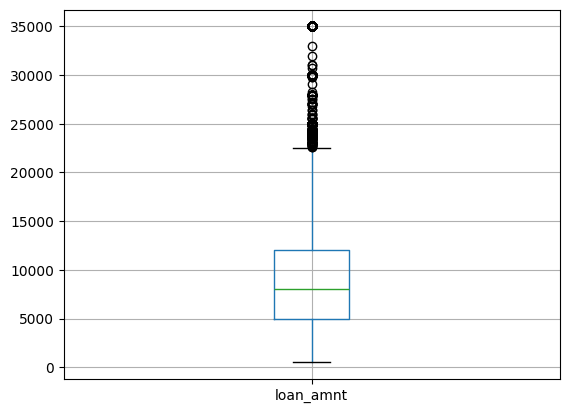

In [10]:
# Creating a boxplot for Loan Amount
train_data[[cols[9]]].boxplot()
plt.show()

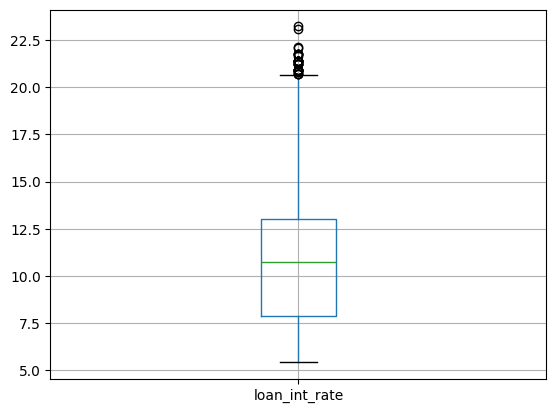

In [11]:
# Creating a boxplot for Loan Interest Rate
train_data[[cols[10]]].boxplot()
plt.show()

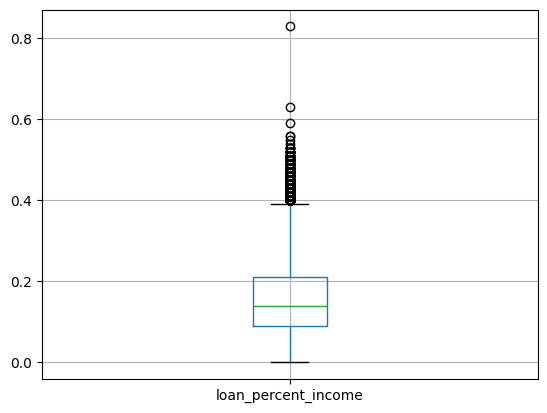

In [12]:
# Creating a boxplot for Loan Percent Income
train_data[[cols[11]]].boxplot()
plt.show()

In [13]:
# Removing the outliers from the data
cleaned_train_data = train_data[train_data.person_emp_length < 70]

# Dropping the id column as it won't contribute to the predictions
cleaned_train_data = cleaned_train_data.drop("id", axis=1)

# Splitting the data into features and labels
cleaned_train_labels = cleaned_train_data["loan_status"]
cleaned_train_data = cleaned_train_data.drop("loan_status", axis=1)

cleaned_train_data

,person_age,person_income,person_home_ownership,person_emp_length,cb_person_default_on_file,cb_person_cred_hist_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income
0,37,35000,RENT,0.0,N,14,EDUCATION,B,6000,11.49,0.17
1,22,56000,OWN,6.0,N,2,MEDICAL,C,4000,13.35,0.07
2,29,28800,OWN,8.0,N,10,PERSONAL,A,6000,8.90,0.21
3,30,70000,RENT,14.0,N,5,VENTURE,B,12000,11.11,0.17
4,22,60000,RENT,2.0,N,3,MEDICAL,A,6000,6.92,0.10
...,...,...,...,...,...,...,...,...,...,...,...
58640,34,120000,MORTGAGE,5.0,Y,10,EDUCATION,D,25000,15.95,0.21
58641,28,28800,RENT,0.0,N,8,MEDICAL,C,10000,12.73,0.35
58642,23,44000,RENT,7.0,N,2,EDUCATION,D,6800,16.00,0.15
58643,22,30000,RENT,2.0,N,3,EDUCATION,A,5000,8.90,0.17


In [14]:
# Retrieivng the columns of the cleaned data
cols = cleaned_train_data.columns

# Retrieving categorical features
categorical_features = [col for col in cols if cleaned_train_data[col].dtype.name == 'object']

# Retrieving numerical features
numerical_features = [col for col in cols if cleaned_train_data[col].dtype.name != 'object']

# Creating a column transformer
transformer = ColumnTransformer(
    [('numerical_transformer', MinMaxScaler(feature_range=(0,1)), numerical_features),
    ('categorical_transformer', OneHotEncoder(handle_unknown='ignore'), categorical_features)]
)

# Preprocessing the data
preprocessed_data = pd.DataFrame(transformer.fit_transform(cleaned_train_data))

preprocessed_data

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.165049,0.016246,0.000000,0.428571,0.159420,0.341011,0.204819,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.019417,0.027324,0.146341,0.000000,0.101449,0.445506,0.084337,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.087379,0.012976,0.195122,0.285714,0.159420,0.195506,0.253012,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.097087,0.034708,0.341463,0.107143,0.333333,0.319663,0.204819,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.019417,0.029433,0.048780,0.035714,0.159420,0.084270,0.120482,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58638,0.135922,0.061082,0.121951,0.285714,0.710145,0.591573,0.253012,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
58639,0.077670,0.012976,0.000000,0.214286,0.275362,0.410674,0.421687,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
58640,0.029126,0.020994,0.170732,0.000000,0.182609,0.594382,0.180723,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
58641,0.019417,0.013609,0.048780,0.035714,0.130435,0.195506,0.204819,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Creating directories to save the preprocessed data and the transformer
os.makedirs("data/preprocess", exist_ok=True)
os.makedirs("transformers", exist_ok=True)

# Saving the preprocessed data an d labels as a csv file
preprocessed_data.to_csv(params['output_data_path'], index=False)
cleaned_train_labels.to_csv(params['output_label_path'], index=False)

# Saving the column transformer as a pickle file
pickle.dump(transformer, open(params['transformer_path'], 'wb'))

### Actual Implementation

In [16]:
# Importing the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
import yaml
import psycopg2
import pickle

from sqlalchemy import create_engine
from urllib.parse import quote

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Creating a function to preprocess data
def preprocess_data():

    # Accessing the params.yaml file
    params = yaml.safe_load(open("params.yaml"))['preprocess']

    # Importing the required configurations for the database
    from config import user, psswd, database, host, port

    # URL-encoding the password to encode the "@"
    encoded_password = quote(psswd)

    # Creating databsase engine
    engine = create_engine(f'postgresql+psycopg2://{user}:{encoded_password}@{host}:{port}/{database}')

    # Defining the select query
    select_query = "SELECT * FROM train_df"

    # Executing the query
    train_data = pd.read_sql(select_query, engine)

    # Describing the data
    train_data.describe()

    # Dropping null values
    train_data = train_data.dropna()

    # Dropping the duplicate values
    train_data = train_data.drop_duplicates()

    # Retriving the columns of the data
    cols = train_data.columns

    # Creating a boxplot for id
    train_data[[cols[0]]].boxplot()

    # Creating a boxplot for Age
    train_data[[cols[1]]].boxplot()

    # Creating a boxplot for Income
    train_data[[cols[2]]].boxplot()

    # Creating a boxplot for Employee Length (employee length greater than 120 is a very big outlier that needs to be removed)
    train_data[[cols[4]]].boxplot()

    # Creating a boxplot for Credit History Length
    train_data[[cols[6]]].boxplot()

    # Creating a boxplot for Loan Amount
    train_data[[cols[9]]].boxplot()

    # Creating a boxplot for Loan Interest Rate
    train_data[[cols[10]]].boxplot()

    # Creating a boxplot for Loan Percent Income
    train_data[[cols[11]]].boxplot()

    # Removing the outliers from the data
    cleaned_train_data = train_data[train_data.person_emp_length < 70]

    # Dropping the id column as it won't contribute to the predictions
    cleaned_train_data = cleaned_train_data.drop("id", axis=1)

    # Splitting the data into features and labels
    cleaned_train_labels = cleaned_train_data["loan_status"]
    cleaned_train_data = cleaned_train_data.drop("loan_status", axis=1)

    # Retrieivng the columns of the cleaned data
    cols = cleaned_train_data.columns

    # Retrieving categorical features
    categorical_features = [col for col in cols if cleaned_train_data[col].dtype.name == 'object']

    # Retrieving numerical features
    numerical_features = [col for col in cols if cleaned_train_data[col].dtype.name != 'object']

    # Creating a column transformer
    transformer = ColumnTransformer(
        [('numerical_transformer', MinMaxScaler(feature_range=(0,1)), numerical_features),
        ('categorical_transformer', OneHotEncoder(handle_unknown='ignore'), categorical_features)]
    )

    # Preprocessing the data
    preprocessed_data = pd.DataFrame(transformer.fit_transform(cleaned_train_data))

    # Creating directories to save the preprocessed data and the transformer
    os.makedirs("data/preprocess", exist_ok=True)
    os.makedirs("transformers", exist_ok=True)

    # Saving the preprocessed data an d labels as a csv file
    preprocessed_data.to_csv(params['output_data_path'], index=False)
    cleaned_train_labels.to_csv(params['output_label_path'], index=False)

    # Saving the column transformer as a pickle file
    pickle.dump(transformer, open(params['transformer_path'], 'wb'))

    # Displaying a success message
    print("\nThe data has been successfully preprocessed!")

    # Returning nothing
    return

# Calling the function to preprocess the data
preprocess_data()


The data has been successfully preprocessed!
